# Macrophage regulatory network

This notebook is part of the methods of the paper:

Cyclic attractors are critical for macrophage differentiation.
Manuel Azaid Ordaz-Arias, Laura Díaz-Alvarez, Mariana Esther Martinez-Sánchez, Yalbi I. Balderas-Martínez

1. [/] Regulatory network
2. [ ] 


In [1]:
library('BoolNet')
library('dplyr')
library('alluvial')
library("stringr")
library('pheatmap')
library('data.table')
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



## Macrophage Regulatory Network and Subsets

* [/] Network
* [/] Subsets (image and table)

In [2]:
# Load data
net <- loadNetwork(file = "data/MP_reduced_network.csv")
lab <- read.csv("data/MP_label_rules.csv")
env <- read.csv("data/MP_environment.csv")

replace.labels <- list('bM1M2'='M1M2', 'M1/M1M2/NoLabel'='M1M2', 'il6/M0/M2/M2c'='M2c', 'il6/M0/M2/M2b'='M2b', 
                       'il6/M0/M1/M2b'='M1M2', 'M1M2/NoLabel'='M1M2', 'M1M2/M1/M1M2'='M1M2', 'il6/M0/M1/M2'='M1M2', 
                       'M1M2/M2/M2d'='M1M2', 'il6/M2b/M2c'='M2', 'M1/NoLabel'='M1M2', 'M0/M2b/M2c'='M2', 
                       'il6/M2/M2c'='M2c', 'il6/M2/M2b'='M2b', 'il6/M1/M2b'='M1M2', 'il6/M0/M2b'='M2b', 'M1/M2/M2c'='M1M2', 
                       'M1/M2/M2b'='M2b', 'M0/M2/M2c'='M2c', 'M0/M2/M2b'='M2b', 'M0/M1/M2b'='M1M2', 'il6/M1/M2'='M1M2', 
                       'il6/M0/M2'='M2', 'il6/M0/M1'='M1', 'M1M2/M2d'='M1M2', 'M0/M1/M2'='M1M2', 'M2b/M2c'='M2', 
                       'M1M2/M2'='M1M2', 'M1M2/M1'='M1M2', 'M1/M1M2'='M1M2', 'il6/M2b'='M2b', 'M2/M2d'='M2d', 'M2/M2a'='M2a', 
                       'M1/M2b'='M1M2', 'M0/M2b'='M2b', 'il6/M2'='M2', 'il6/M1'='M1', 'il6/M0'='il6', 'M1/M2'='M1M2', 
                       'M0/M2'='M2', 'M0/M1'='M1')


In [3]:
simplifyLabel <- function(old, sep='/', mark='*', replace=NULL) { 
    new <- str_split(old,sep)
    new <- sort(unique(new[[1]]))
    new <- paste(new, collapse=sep)
    if (! is.null(replace)) {
        for (key in names(replace)) {
                new <- str_replace( new, pattern=key, replace[[key]] )
            }
        }
    if (! is.null(mark)) { 
        if (new!=old) {
            new <- paste(c(new,mark), collapse='')
        }
    }
    new
}

get.first.state <- function(s, sep='/') {
    s <- as.character(s)
    s <- strsplit(s,'/')[[1]]
    if (length(s)>1) s <- s[[1]]
    s <- as.integer(s)
    s
}


plot.heatmap <- function(attr.table, title='', gaps=NULL){
   pheatmap(t(as.matrix( subset(attr.table, select=-label ))),
            labels_col = attr.table[,"label"], main= title, 
            color=c('#fb8072','#b3de69'), scale = "none", 
            fontsize_col=8,
            cluster_cols = F, cluster_rows = F,gaps_col = gaps
   )
}

### Network

<img src="images/MP_full_graph.jpg" alt="MP full graph" style="width: 500px;"/>
Macrophage complete regulatory network

<img src="images/MP_reduced_graph.png" alt="MP reduced graph" style="width: 500px;"/>
Macrophage simplified regulatory network

### Attractors

In [4]:
file.attr <- "data/MP_attractors.csv"
file.label <- "data/MP_attr_label_wt.csv"

if (! file.exists(file.attr)) {
    # calculate attractors
    attr <- getAttractors(net, method="sat.exhaustive")
    saveRDS(attr, file = "data/MP_attractors.rds")
    attr.table <- attractorToDataframe(attr, Boolean=TRUE)
    
    l_long <- labelAttractors(attr, lab, net$genes)
    labels <- data.frame(attractor=NA, label=NA)[numeric(0), ]
    for (a in 1:length(l_long)) {
        l <- simplifyLabel(l_long[[a]], replace=replace.labels)
        labels[nrow(labels) + 1,] = c(a,l)
    }
    
    state.label <- data.frame(state=integer(), attractor=integer())
    for (n in 1:length(attr$attractors)) {
        states <- attr$attractors[[n]]$involvedStates
        for (s in states) {
            state.label[nrow(state.label) + 1,] = c(s,n)
            }
        }
    state.label <- merge(x=state.label, y=labels, by="attractor", all = TRUE)
    attr.table <- merge(x = labels, y = attr.table, by = "attractor", all = TRUE)
    labels <- state.label
    write.csv(attr.table, file.attr, row.names=FALSE)
    write.csv(labels, file.label, row.names=FALSE)
} else {
    attr.table <- read.csv(file = file.attr)
    labels <- read.csv(file = file.label)
}
unique(attr.table$label)

[1] M0    M1    M2    M1*   M1M2* il6*  M2*   M2a   M2b*  M2c*  M2d*  M2d  
[13] M2b   M2c  
Levels: il6* M0 M1 M1* M1M2* M2 M2* M2a M2b M2b* M2c M2c* M2d M2d*

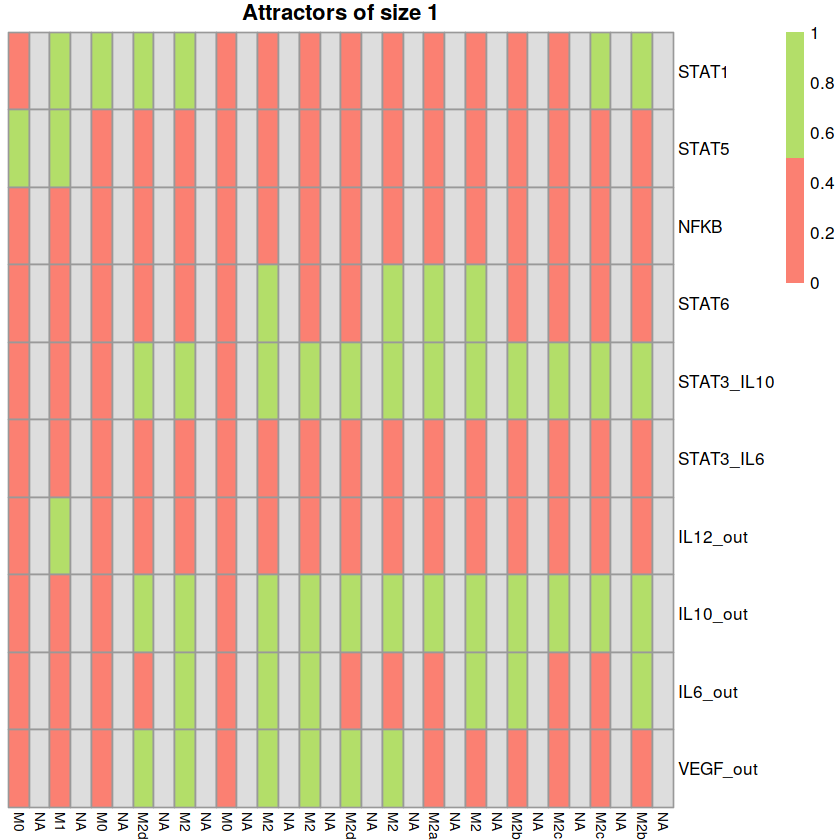

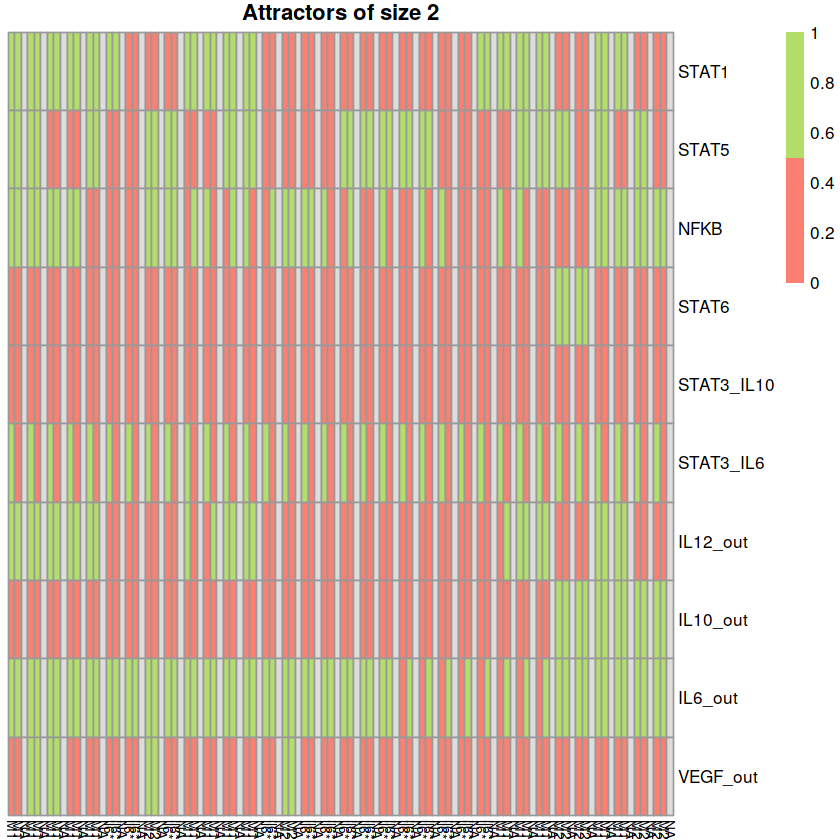

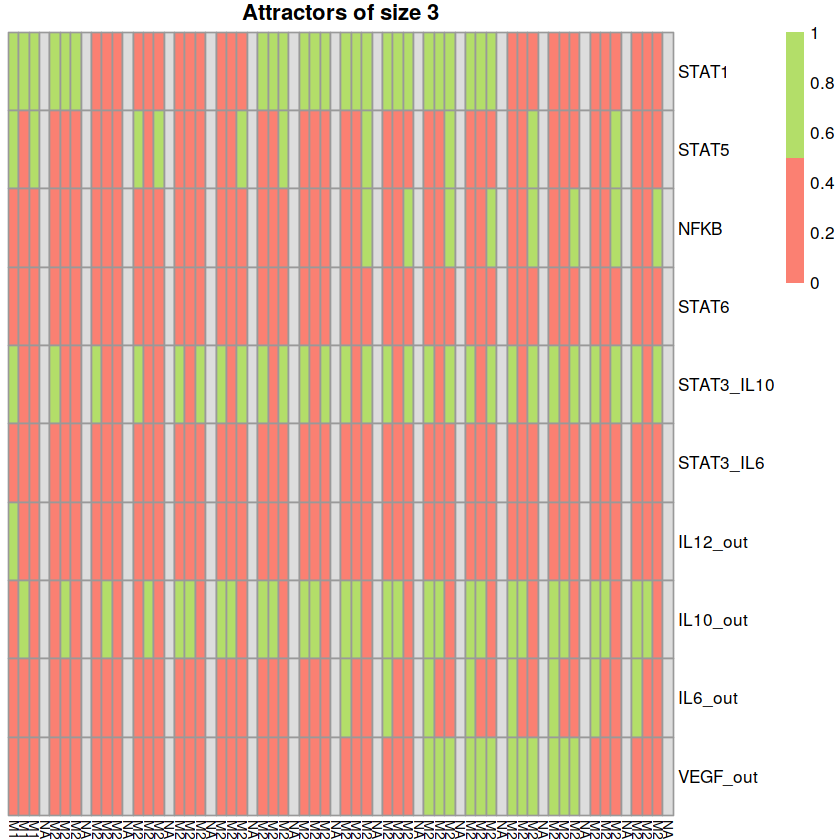

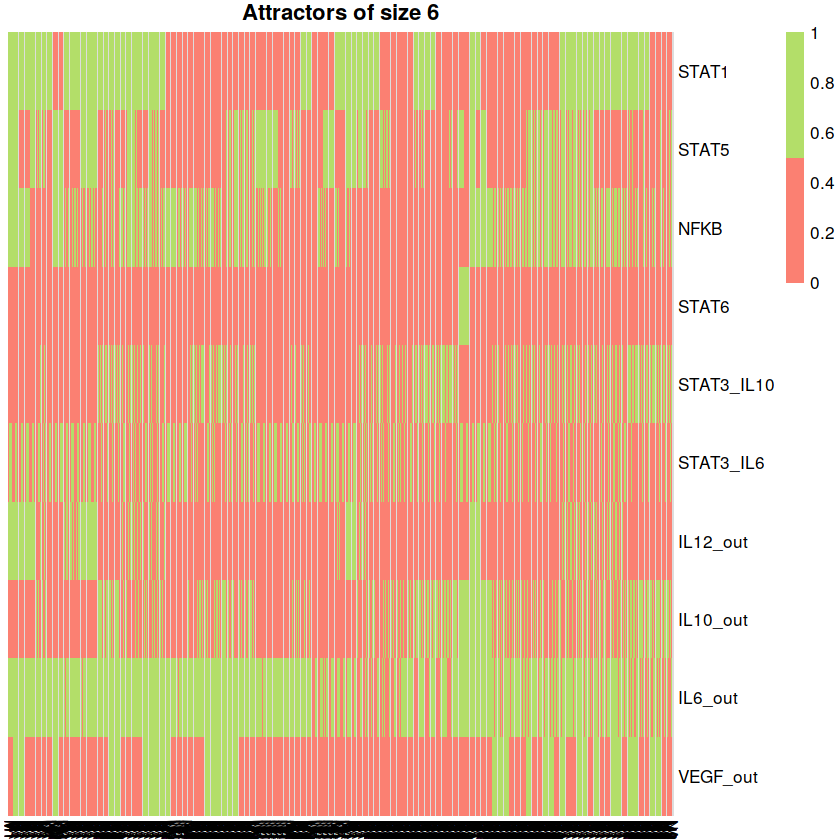

In [5]:
file.wt.attr.pdf <- "images/MP_attractor_all"

# Select key nodes for plotting
node.subset <- c("STAT1", "STAT5", "NFKB", "STAT6", "STAT3_IL10", "STAT3_IL6", "IL12_out", "IL10_out", "IL6_out", "VEGF_out")
attr.table.short <- subset(attr.table, select = c("attractor","label","state", node.subset) )

# select unique attractors of subset
attrs <- list()
for (n in 1:max(attr.table$attractor)) {
    at <- attr.table.short[attr.table.short$attractor==n,]
    at <- subset(at, select = -c(attractor,state) )
    at[nrow(at) + 1,] = NA
    row.names(at) <- NULL
    attrs[[n]] <- at
}
attrs <- unique(attrs)


for (n in c(1,2,3,6)) {
    attrs_f <- Filter(function(x) (nrow(x))-1==n, attrs)
    attrs_f <- bind_rows(attrs_f)
    title = paste(c('Attractors of size ',n), collapse='')
    #pdf( paste(c(file.wt.attr.pdf,as.character(n),'.pdf'),collapse='') )
    plot.heatmap(attrs_f, title=title)
    #dev.off()
}


Nodes in cycle

In [6]:
df.col.means <- function(df) {
    df[,2:ncol(df)] <- colMeans(df[,2:ncol(df)], na.rm=T)
    df[1,]
    }

attr.mean <- bind_rows( lapply(attrs, df.col.means) )
attr.mean <- attr.mean[ with(attr.mean, order(label)),]
attr.mean <- distinct(attr.mean)
attr.mean[,2:ncol(attr.mean)] <- attr.mean[,2:ncol(attr.mean)]!=0 &attr.mean[,2:ncol(attr.mean)]!=1
attr.mean %>% group_by(label) %>% summarize_all(sum)

label,STAT1,STAT5,NFKB,STAT6,STAT3_IL10,STAT3_IL6,IL12_out,IL10_out,IL6_out,VEGF_out
il6*,0,0,0,0,11,25,11,0,0,0
M0,0,0,0,0,0,0,0,0,0,0
M1,0,0,0,0,0,0,0,0,0,0
M1*,0,0,2,0,9,18,9,0,3,0
M1M2*,0,15,14,8,10,22,13,0,14,1
M2,0,0,0,0,0,0,0,0,0,0
M2*,0,15,13,6,7,20,12,0,0,0
M2a,0,0,0,0,0,0,0,0,0,0
M2b,0,0,0,0,0,0,0,0,0,0
M2b*,0,23,23,12,8,25,16,2,2,0


### Basin size

In [7]:
attr.basin <- read.csv("data/MP_basin.csv")
attr.basin$involvedStates <- sapply(attr.basin$involvedStates, get.first.state  )
attr.basin <- merge(x=attr.basin, by.x='involvedStates', 
                    y=labels[c('state','label')], by.y="state", all.x = TRUE)
attr.basin <- subset(attr.basin, select = -involvedStates )
attr.basin <- attr.basin %>% group_by(label) %>% summarize_all(sum)
attr.basin$basinSize <- attr.basin$basinSize/sum(attr.basin$basinSize) *100
colnames(attr.basin) <- c('label','basin%')
attr.basin

label,basin%
il6*,0.099205971
M0,0.008368492
M1,0.002789497
M1*,0.084948540
M1M2*,10.668945312
M2,20.565032959
M2*,20.329999924
M2a,12.681198120
M2b,7.973289490
M2b*,14.999532700


## Mutants

In [8]:
file.mutants <- 'data/MP_attr_mutants.csv'

if (! file.exists(file.mutants)) {
    # calculate attractors
    mutants <- perturbNetworkFixedNodes(net, label.rules=lab, 
                                        returnDataFrame='occurrence', method="sat.exhaustive")
    setDT(mutants, keep.rownames = TRUE)
    colnames(mutants)[[1]] <-'label'
    mutants$label <- sapply(mutants$label, simplifyLabel, replace=replace.labels)
    mutants <- mutants %>% group_by(label) %>% summarize_all(sum)
    write.csv(mutants, file.mutants, row.names=F)
} else {
    mutants <- read.csv(file = file.mutants, row.names=1)
    mutants[mutants == 0] <- NA
}
mutants[0:5,]

,WT,STAT1_0,STAT5_0,IL1R_0,IL12_out_0,FCGR_0,NFKB_0,VEGF_out_0,TLR4_0,IL6_out_0,...,IFNG_e_1,GMCSF_e_1,IL1B_e_1,IC_e_1,LPS_e_1,NECA_e_1,EGFR_e_1,IL4_e_1,IL6_e_1,IL10_e_1
il6,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
il6*,304,560,328,140,560,368,144,336,424,NA,...,24,140,48,120,32,136,176,NA,176,NA
M0,24,32,32,36,32,24,48,24,36,56,...,8,8,NA,12,NA,12,12,NA,NA,NA
M0*,NA,NA,NA,NA,NA,NA,NA,NA,NA,192,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
M1,8,NA,NA,12,NA,8,16,8,12,40,...,8,8,NA,4,NA,4,4,NA,NA,NA


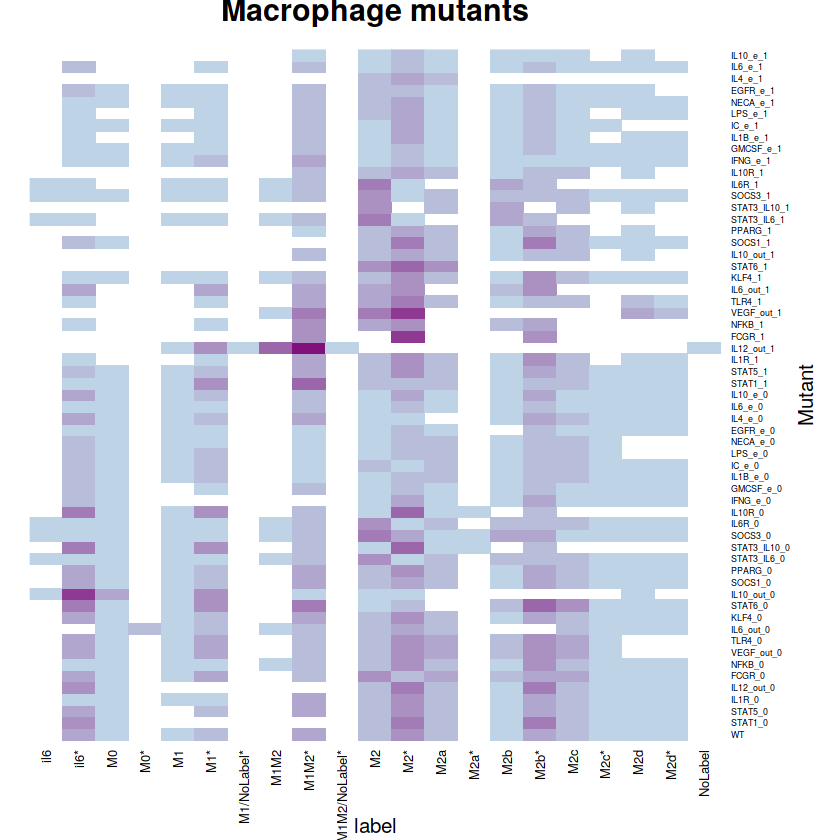

In [9]:
file.attr.pdf = 'images/MP_mutants.pdf'
normalize = F

if (normalize) {
    mutants <- mutants/mutants
    color <- c('#bebada')
} else {
    colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
    color <- colfunc(10)
}

#pdf(file.attr.pdf)
heatmap(t(as.matrix( mutants )),
        main="Macrophage mutants", 
        xlab="label", ylab="Mutant",
        col=color, cexCol=0.75, cexRow=0.5,
        Colv = NA, Rowv = NA, scale="none",
        )
#dev.off()

## Enviroments

In [10]:
env

,IFNG_e,GMCSF_e,LPS_e,IC_e,IL1B_e,NECA_e,IL6_e,IL4_e,IL10_e
pro-M1,1,1,1,0,0,0,0,0,0
pro-M2a,0,0,0,0,0,0,0,1,0
pro-M2b,0,0,1,1,1,0,0,0,0
pro-M2c,0,0,0,0,0,0,0,0,1
pro-M2d,0,0,1,0,0,1,1,0,0


In [11]:
file.env.attr <- "data/MP_env_attr.csv"

if (! file.exists(file.env.attr)) {
    env.attr <- perturbNetworkFixedNodes(net, label.rules=lab, , returnDataFrame='occurrence', method="sat.exhaustive",
                              genes  = rep( list(colnames(env)), times=nrow(env) ),
                              values = lapply( split(env,seq_along(env[,1])), as.list),
                              names  = rownames(env))
    setDT(env.attr, keep.rownames = TRUE)
    colnames(env.attr)[[1]] <- 'label'
    env.attr$label <- sapply(env.attr$label, simplifyLabel, replace=replace.labels)
    env.attr <- env.attr %>% group_by(label) %>% summarize_all(sum)
    #write.csv(mutants, file.mutants, row.names=F)
    env.attr
    write.csv(env.attr, file.env.attr, row.names=F)
} else {
    env.attr <- read.csv(file = file.env.attr, row.names=1)
    env.attr[env.attr == 0] <- NA
}

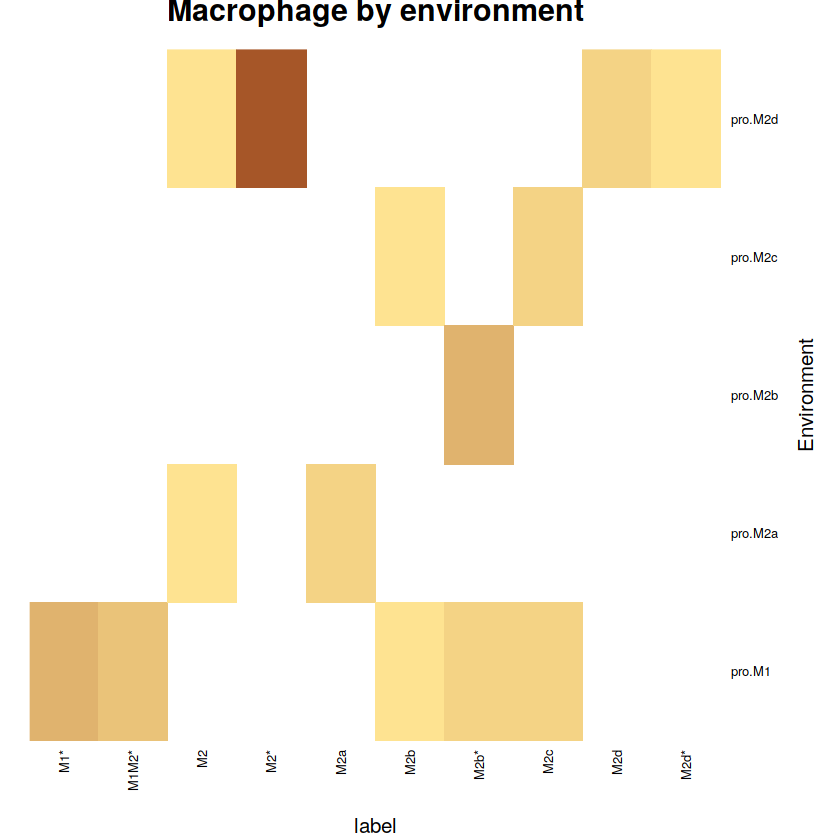

In [12]:
file.env.attr.pdf <- "images/MP_env_attr.pdf"

normalize = F
if (normalize) {
    env.attr <- env.attr/env.attr
    color = '#a65628'
} else { 
    colfunc <- colorRampPalette(c('#fee391', '#a65628'))
    color <- colfunc(10)
}

#pdf(file.env.attr.pdf)
heatmap(t(as.matrix( subset(env.attr ))),
        main="Macrophage by environment", 
        xlab="label", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
#dev.off()

## Macrophage Plasticity

In [13]:
file.cfm <- "data/MP_cfm_label.csv"
if (! file.exists(file.cfm)) {
    cfm <- cellFateMap(net, method="sat.exhaustive", maxAttractorLength=6) 
    cfm <- apply(cfm,2,as.character)
    cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
    cfm$final <- sapply(cfm$final, get.first.state)
    cfm.label <- merge(x=cfm, y=labels[c('state','label')], by.x='initial', by.y="state", all.x = TRUE)
    colnames(cfm.label)[5] <- 'initial_label'
    cfm.label <- merge(x=cfm.label, y=labels[c('state','label')], by.x='final', by.y="state", all.x = TRUE)
    colnames(cfm.label)[6] <- 'final_label'
    write.csv(cfm.label, file.cfm)
} else {
    cfm.label <- read.csv(file = file.cfm, row.names=1)
}
cfm.label[1000:1005,]

,final,initial,genes,values,initial_label,final_label
1000,886785,672045,STAT6,1,M1*,M2c
1001,886785,557057,IL4_e,1,M2*,M2c
1002,886785,819201,IL10_out,1,M2c*,M2c
1003,886785,591873,STAT6,1,M2*,M2c
1004,886785,737581,STAT6,1,M1*,M2c
1005,886785,786433,IL10_out,1,M2*,M2c


### Transitions by node

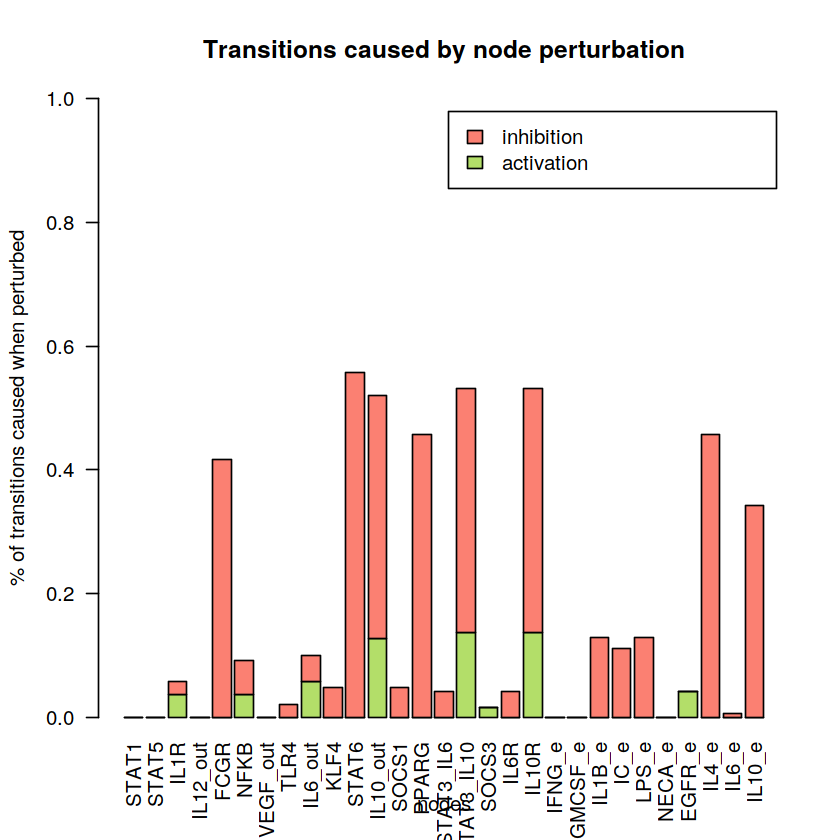

In [14]:
cfm.diff <- cfm.label[cfm.label$initial_label!=cfm.label$final_la,]
node.transitions <- merge( summary(cfm.diff[cfm.diff$values==0,'genes']), 
                           summary(cfm.diff[cfm.diff$values==1,'genes']),
                           by=0, all=TRUE)
rownames(node.transitions) <- node.transitions$Row.names
node.transitions <- subset(node.transitions, select = -Row.names )
colnames(node.transitions) <- c('activation','inhibition')
node.transitions <- node.transitions[net$genes,]
node.transitions <- node.transitions/summary(cfm.label$genes)

#pdf("images/MP_transitionnode.pdf") 
barplot(t(as.matrix( node.transitions )),
        main="Transitions caused by node perturbation", 
        xlab='nodes', ylab='% of transitions caused when perturbed',
        col=c('#b3de69','#fb8072'), ylim=c(0,1), las=2, legend=T,
       )
#dev.off()
#node.transitions

### Transitions by label

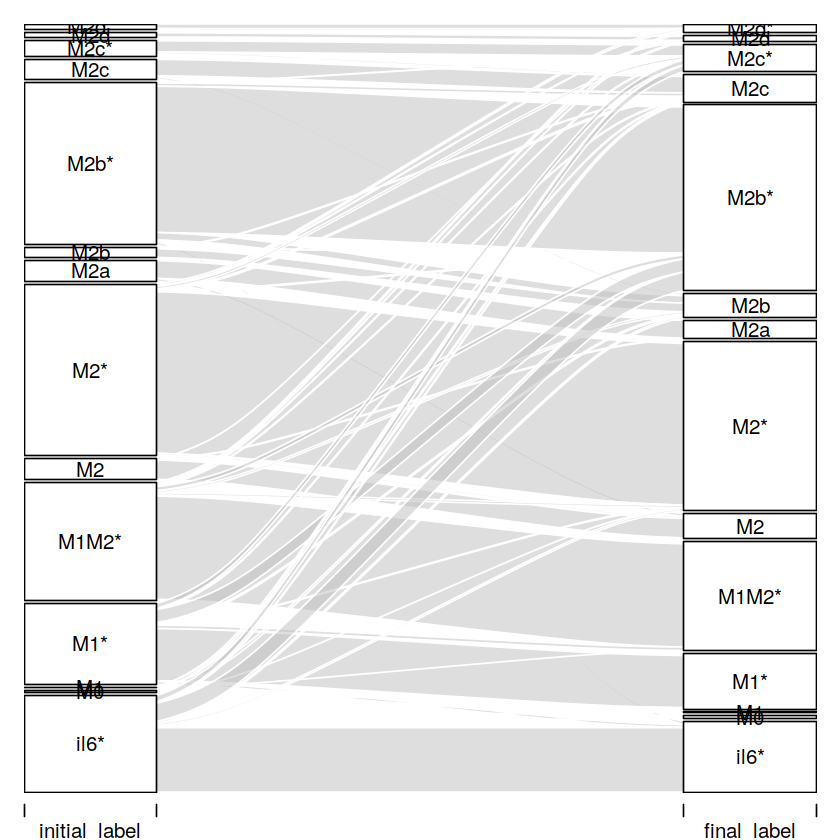

In [15]:

#pdf('images/MP_alluvial.pdf')
cfm2d <- cfm.label %>% group_by(initial_label, final_label) %>%
            summarize(freq = n())
alluvial(cfm2d[,1:2], freq=cfm2d$freq)
#dev.off()
